<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/khf7_Vasarely.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/vasarely.bmp

--2024-12-06 19:41:28--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/vasarely.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3055670 (2.9M) [image/bmp]
Saving to: ‘vasarely.bmp’

vasarely.bmp        100%[===================>]   2.91M  --.-KB/s    in 0.08s   

2024-12-06 19:41:29 (37.6 MB/s) - ‘vasarely.bmp’ saved [3055670/3055670]



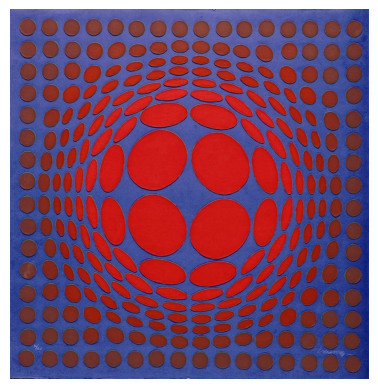

In [4]:
# Kép betöltése
img = cv2.imread('vasarely.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img)

## BLOB-ok szín szerinti szegmentálása

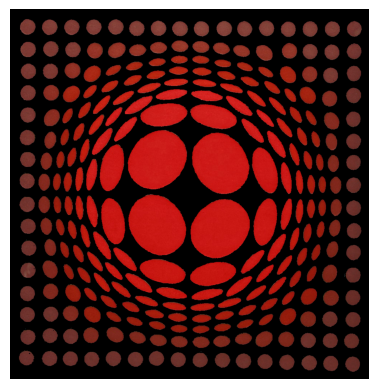

In [21]:
#(forrás: https://ujangriswanto08.medium.com/a-beginners-guide-to-image-segmentation-using-color-masking-3a3fd536ed25)

# Áttérés HSV színtérre
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Maszk definiálása
lower_red = np.array([0, 80, 80]) # Hue, Saturation, Value
upper_red = np.array([100, 255, 255])
red_mask = cv2.inRange(img_hsv, lower_red, upper_red)

# Maszk alkalmazása a képre
img_segmented = cv2.bitwise_and(img, img, mask=red_mask)

plt.axis("off")
plt.imshow(img_segmented)

## BLOB-ok detektálása

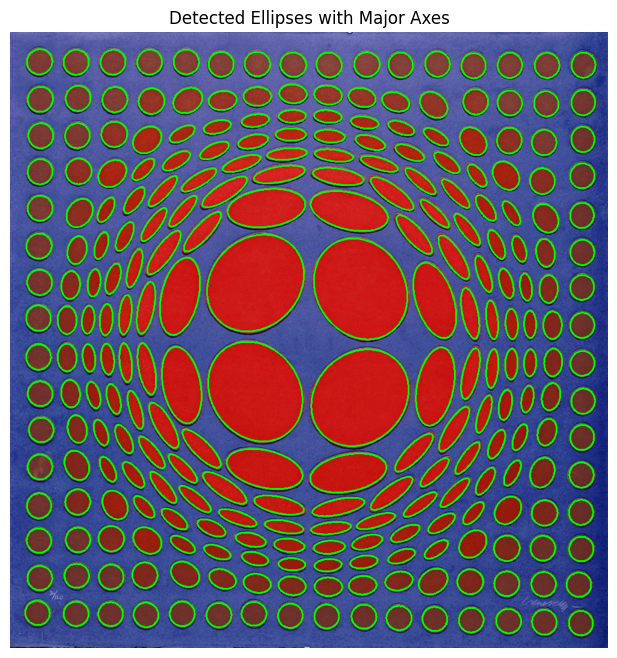

In [31]:
# Maszk binarizálása a biztonság kedvéért
_, red_mask_binary = cv2.threshold(red_mask, 127, 255, cv2.THRESH_BINARY)

# Ellipszis kontúrok és főtengelyek megkeresése
contours, _ = cv2.findContours(red_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# store (x, y, major_axis_length) tuples in major_axes
major_axes = []

img_with_contours = img

for contour in contours:
  if len(contour) >= 10: # Ennyi találat kell, hogy valamit ellipszisnek számítsunk
      ellipse = cv2.fitEllipse(contour)
      center, axes, angle = ellipse
      major_axis = max(axes)
      major_axes.append(center, axes, angle)

      # Draw the ellipse on the output image
      cv2.ellipse(img_with_contours, ellipse, (0, 255, 0), 2)

plt.axis("off")
plt.imshow(img_with_contours)

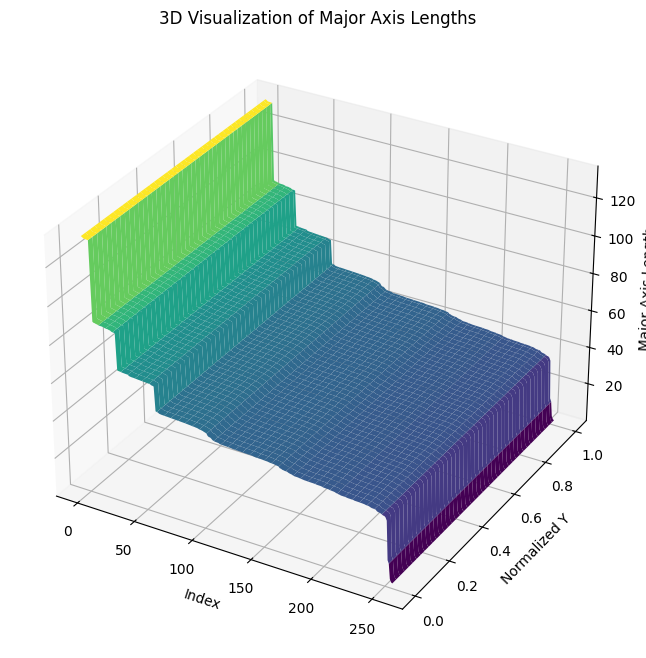

In [13]:
# Remove the first element, which is an outlier
if major_axes:
    major_axes.pop(0)  # Remove the largest (erroneous) value

# Prepare for 3D visualization
# Generate a mesh grid for plotting
x_coords = np.linspace(0, len(major_axes), len(major_axes))
y_coords = np.linspace(0, 1, len(major_axes))  # Arbitrary normalization for display
X, Y = np.meshgrid(x_coords, y_coords)
Z = np.tile(major_axes, (len(y_coords), 1))  # Repeat major axes for 3D surface

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('3D Visualization of Major Axis Lengths')
ax.set_xlabel('Index')
ax.set_ylabel('Normalized Y')
ax.set_zlabel('Major Axis Length')
plt.show()


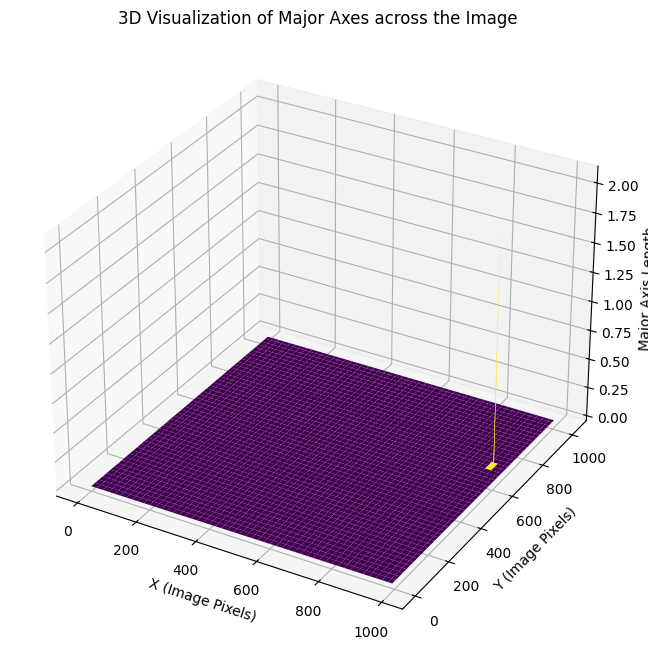

In [14]:
# Create a blank grid for the Z values (same dimensions as the image)
z_values = np.zeros(image.shape[:2], dtype=np.float32)

# Assign major axis length to pixels based on proximity to the nearest ellipse center
for contour in contours:
    if len(contour) >= 5:  # Only process valid ellipses
        ellipse = cv2.fitEllipse(contour)
        (center, axes, angle) = ellipse
        major_axis = max(axes)

        # Get the ellipse center as integer coordinates
        center_x, center_y = map(int, center)

        # Assign the major axis value to the corresponding region around the center
        cv2.circle(z_values, (center_x, center_y), int(axes[0] / 2), major_axis, thickness=-1)

# Create a mesh grid for the image dimensions
x_coords = np.arange(z_values.shape[1])  # Width corresponds to x-axis
y_coords = np.arange(z_values.shape[0])  # Height corresponds to y-axis
X, Y = np.meshgrid(x_coords, y_coords)

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z_values, cmap='viridis', edgecolor='none')
ax.set_title('3D Visualization of Major Axes across the Image')
ax.set_xlabel('X (Image Pixels)')
ax.set_ylabel('Y (Image Pixels)')
ax.set_zlabel('Major Axis Length')
plt.show()


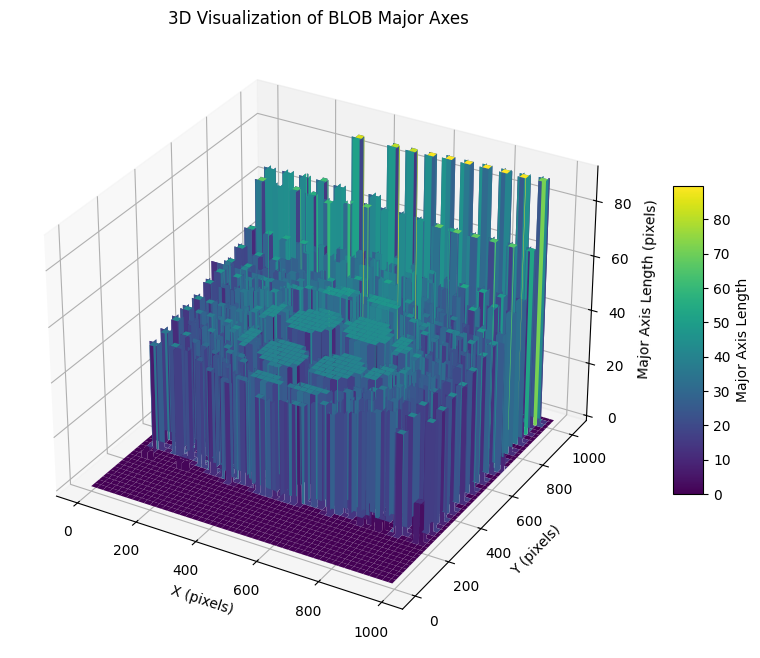

In [15]:
# Create a blank Z-map (same size as the original image)
height_map = np.zeros(image.shape[:2], dtype=np.float32)

# Assign major axis lengths to the corresponding pixel regions of each ellipse
for contour, major_axis in zip(contours, major_axes):
    if len(contour) >= 5:  # Fit ellipses only for valid contours
        ellipse = cv2.fitEllipse(contour)
        mask = np.zeros_like(red_mask_binary)  # Blank mask
        cv2.ellipse(mask, ellipse, 255, thickness=-1)  # Draw filled ellipse
        height_map[mask == 255] = major_axis  # Assign major axis length to pixels in the ellipse

# Generate a meshgrid for the 3D plot
x = np.arange(0, height_map.shape[1])
y = np.arange(0, height_map.shape[0])
X, Y = np.meshgrid(x, y)
Z = height_map

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('3D Visualization of BLOB Major Axes')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Major Axis Length (pixels)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Major Axis Length')
plt.show()


In [21]:
# Calculate the centers of the blobs from the ellipses
blob_centers = []
for contour in contours:
    if len(contour) >= 5:  # Ensure enough points for ellipse fitting
        ellipse = cv2.fitEllipse(contour)
        center = ellipse[0]  # Center of the ellipse
        blob_centers.append(center)

# Create a blank height map with the same size as the image
height_map = np.zeros(image.shape[:2], dtype=np.float32)

# Map each pixel to the closest blob center
image_height, image_width = height_map.shape
for y in range(image_height):
    for x in range(image_width):
        # Compute distances to all blob centers
        distances = [np.linalg.norm(np.array((x, y)) - np.array(center)) for center in blob_centers]
        if distances:
            # Find the index of the closest blob
            closest_blob_index = np.argmin(distances)
            # Assign the major axis length of the closest blob
            height_map[y, x] = major_axes[closest_blob_index]

# Visualize the 3D height map
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(image_width), np.arange(image_height))
ax.plot_surface(X, Y, height_map, cmap='viridis', edgecolor='none')
ax.set_title('3D Surface Plot of Major Axes')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Major Axis Length (z)')
plt.show()


IndexError: list index out of range